
# Introduction

Cardiff is the Capital of Wales, United Kingdom also one of the popular tourist location. Opening an outlet can become challenging for retailer. 

The analysis will scrape into various venues in the area and the aim will be a location suitable for the retailer

This will involve machine learning model (k-means) to cluster the venues of shortlisted places and analyse it to choose a desirable location

# Problem Statement

An investor wants to buy a shop in a particular location in Cardiff.

He wants to get a venue that's popular in town but also falls into an optimal location
The goal is to find a location for the user for its choice of venue

# Data

In this Project, we’ll be taking data from only one source

Using only foursquare API we will extract venues that are nearby and trending
Also applying some location and venue constraints to get required data



# Methedology 

In [2]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install geocoder

Note: you may need to restart the kernel to use updated packages.


In [63]:
pip install wordcloud

     |████████████████████████████████| 364 kB 95 kB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [1]:
# importing libraries 
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import folium
import geocoder
from wordcloud import WordCloud

get_ipython().magic(u'matplotlib inline')

In [2]:
#define the url components

client_id = 'FX3VCRT3ZNFFR13BF4WJREOU0TYHU1UEV4E5HMGUGI53H5IW'
client_secret = 'QSNVXXMDA5AFZ54JM4PPX42D1RNMY4WRMUIA04ZV3DMFEFJN'
limit = 10
radius = 500
version = '20180605'

In [5]:
# Create a Map 

cardiff = folium.Map([51.481583,-3.179090],zoom_start= 12)
cardiff 

In [4]:
def category_type(row):
    
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list)==0:
        return None
    else:
        return(categories_list[0]['name'])

# Extracting the overall venues around Cardiff

Cardiff is the Capital of Wales,UK 

In [7]:
location = 'Cardiff,United Kingdom'

radius = 10000
limit = 200
    
address = location
geolocator = Nominatim(user_agent='foursquare_agent')
loc = geolocator.geocode(address)
latitude = loc.latitude
longitude = loc.longitude
    
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(client_id,client_secret,version,latitude,longitude,radius,limit)
    
results = requests.get(url).json()
items = results['response']['groups'][0]['items']
venues = pd.json_normalize(items)

# Cleaning user_df
    
filtered_col = [col for col in venues.columns if col.startswith ('venue.')]

#Creating a new_df with filtered columns

explore_df = venues.loc[:,filtered_col]
explore_df['venue.categories']=explore_df.apply(category_type,axis=1)
explore_df.columns = [column.split('.')[-1] for column in explore_df.columns]

#dropping unwanted columns

explore_df.drop(['labeledLatLngs','distance','postalCode','cc','state','count','crossStreet','id','neighborhood','groups'],axis = 1, inplace = True)
explore_df.rename(columns={'id':'ID','name':'Name','categories':'Category','lat':'Latitude','lng':'Longitude','address':'Address','formattedAddress':'Detailed Address','city':'City','country':'Country'}, inplace = True)
explore_df.replace(np.nan, 'Not Mentioned', inplace= True)    

print(explore_df.head())
print(explore_df.shape)

                         Name                            Address   Latitude  \
0                   Bute Park                          Castle St  51.483868   
1  Uncommon Ground Coffee Co.                       Royal Arcade  51.478297   
2         Pettigrew Tea Rooms  West Lodge, Bute Park & Arboretum  51.481361   
3           The New York Deli              19 High Street Arcade  51.480866   
4             BrewDog Cardiff                     31 Westgate St  51.478697   

   Longitude     City         Country  \
0  -3.185349  Cardiff  United Kingdom   
1  -3.177394  Cardiff  United Kingdom   
2  -3.184665  Cardiff  United Kingdom   
3  -3.179226  Cardiff  United Kingdom   
4  -3.179406  Cardiff  United Kingdom   

                                    Detailed Address       Category  
0     [Castle St, Cardiff, CF10 3DX, United Kingdom]           Park  
1  [Royal Arcade, Cardiff, CF10 1AE, United Kingdom]    Coffee Shop  
2  [West Lodge, Bute Park & Arboretum (Castle Str...       Tea Room 

In [8]:
explore_df['Category'].value_counts()

Coffee Shop                      10
Pub                               7
Park                              7
Café                              6
Ice Cream Shop                    3
Restaurant                        3
Indian Restaurant                 2
Rugby Stadium                     2
Beer Bar                          2
Theater                           2
Japanese Restaurant               2
Burger Joint                      2
Vegetarian / Vegan Restaurant     2
Seafood Restaurant                2
Bakery                            2
Tea Room                          2
Deli / Bodega                     2
Steakhouse                        2
Soccer Field                      2
Science Museum                    1
Pastry Shop                       1
Shopping Plaza                    1
Brewery                           1
Dessert Shop                      1
Harbor / Marina                   1
Shopping Mall                     1
French Restaurant                 1
American Restaurant         

Visualiazing all locations on map

In [9]:
for label, lat, lon in zip(explore_df.Name,explore_df.Latitude,explore_df.Longitude):
    
    label = folium.Popup(label,parse_html = True)
    folium.CircleMarker([lat,lon],
                       radius = 5,
                       popup=label,
                       color='red',
                        fill=True,
                        fill_opacity=0.6,
                        parse_html=False).add_to(cardiff)
cardiff

Majority venues are concentrated near city center

In [10]:
# CLEANING UP THE DF
#Assigning common names to common venues

name = explore_df[['Category']]
name['Category'].replace({'Coffee Shop':'Café','Bar':'Pub'},inplace=True)
for value in name['Category']:
    lst =list(value.split())
    if lst[-1]=='Bar':
        name['Category'].replace(value,'Pub',inplace = True)
    elif lst[0] in {'Pizza','Burger','Steakhouse','Deli','Food','Hotel'}or lst[-1] =='Restaurant':
        name['Category'].replace(value,'Restaurant',inplace = True)
    elif lst[0] in {'Ice','Dessert'}:
        name['Category'].replace(value,'Dessert',inplace = True)
    elif lst[-1]=='Track':
        name['Category'].replace(value,'Go-Kart',inplace = True)
    elif lst[-1] =={'Mall','Plaza'}:
        name['Category'].replace(value,'Mall',inplace = True)
    elif lst[0]=={'Castle','Monument'}:
        name['Category'].replace(value,'Monument',inplace = True)   

/home/simran/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [11]:
obj=[]
for value in name['Category']:
    lst = list(value.split())
    
    if len(lst)==1:
        obj.append(lst[0])
    else:
        obj.append(lst[-1]) 
df = pd.DataFrame(data=obj) 
df.index.name = 'Name'
df.rename(columns={0:'Count'},inplace= True)
total = pd.DataFrame(df['Count'].value_counts()) 
print('Sum =',total['Count'].sum())
print(total)

Sum = 100
            Count
Restaurant     29
Café           16
Pub            11
Park            7
Dessert         4
Shop            4
Store           3
Room            2
Plaza           2
Bakery          2
Field           2
Theater         2
Venue           2
Museum          2
Stadium         2
Landmark        1
Castle          1
Hostel          1
Gym             1
Brewery         1
Market          1
Speakeasy       1
Marina          1
Go-Kart         1
Mall            1


From the above observation, we can roughly make out that Restaurants are more in Cardiff followed by Coffee shops and Bars

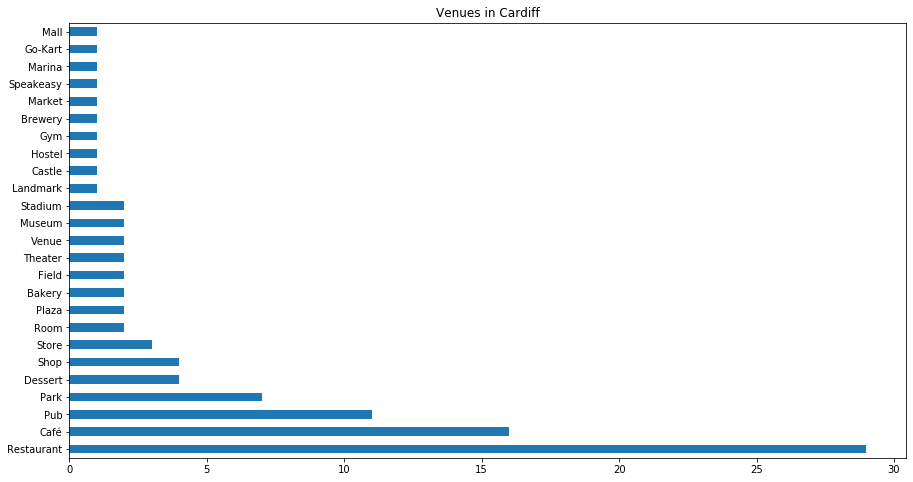

In [12]:
df['Count'].value_counts().plot(kind = 'barh',figsize=(15,8),title='Venues in Cardiff')

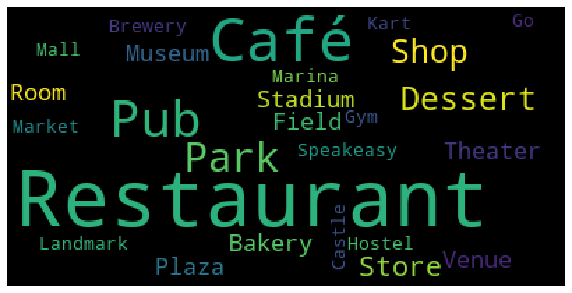

In [13]:
# Making a WordCloud

wordcloud2 = WordCloud().generate(' '.join(df['Count']))
#generate plot
plt.figure(figsize = (10,8), facecolor = None)
plt.imshow(wordcloud2)
plt.axis('off')
plt.show()

Visibly RESTAURANT are more concentrated in Cardiff

Plotting Restaurants in the map

In [14]:
# Getting df with all restaurants
restaurants = pd.DataFrame()
for value in explore_df['Category']:
    lst = list(value.split())
    if lst[-1] in {'Restaurant','Joint'} or lst[0] in {'Pizza','Steakhouse','Hotel','Food','Deli'}:
        data = explore_df.loc[explore_df['Category'] == value]
        restaurants = restaurants.append(data,ignore_index=True)
print(restaurants.shape)

(49, 8)


In [15]:
restaurants.head()

,Name,Address,Latitude,Longitude,City,Country,Detailed Address,Category
0,The New York Deli,19 High Street Arcade,51.480866,-3.179226,Cardiff,United Kingdom,"[19 High Street Arcade, Cardiff, CF10 1BB, Uni...",Deli / Bodega
1,Market Deli,"8-12 Central Market, St Mary St",51.479980,-3.178761,Cardiff,United Kingdom,"[8-12 Central Market, St Mary St, Cardiff, CF1...",Deli / Bodega
2,Wahaca,51-53 The Hayes,51.478059,-3.175173,Cardiff,United Kingdom,"[51-53 The Hayes, Cardiff City Centre, Cardiff...",Mexican Restaurant
3,Miller & Carter,9-11 The Hayes,51.479687,-3.176286,Cardiff,United Kingdom,"[9-11 The Hayes, Cardiff, CF10 1AH, United Kin...",Steakhouse
4,Miller & Carter,Hemingway Rd,51.468275,-3.159345,Cardiff,United Kingdom,"[Hemingway Rd (Atlantic Wharf), Cardiff Bay, C...",Steakhouse


In [16]:
## Map

incidents = folium.map.FeatureGroup()

latitudes = restaurants.Latitude
longitudes = restaurants.Longitude
label = restaurants.Name

for lat,lon,label in zip(latitudes,longitudes,label):
    
    folium.Marker([lat,lon],popup=label).add_to(cardiff)
cardiff.add_child(incidents)
cardiff

# Finding Trending venues in Cardiff

In [17]:
location = 'Cardiff, United Kingdom'
    
address = location
geolocator = Nominatim(user_agent='foursquare_agent')
loc = geolocator.geocode(address)
latitude = loc.latitude
longitude = loc.longitude
    
url = 'https://api.foursquare.com/v2/venues/trending?client_id={}&client_secret={}&v={}&ll={},{}'.format(client_id,client_secret,version,latitude,longitude)
    
results = requests.get(url).json()

if len(results['response']['venues'])==0:
    print('*** No trending venues ***')
else:
    items = results['response']['venues']
    trending = pd.json_normalize(items)

*** No trending venues ***


Seems like there is no trending venue in cardiff to display

Now, Acting upon the problem statement

Since, the most popular venue is a Restaurant, the investor will put it's money into a food joint.

Furthermore, we will expand and visualize different restaurants in the town and suggest the best fit according to the location.

In [18]:
location = 'Cardiff, United Kingdom'

query = 'Restaurant'
limit = 200

address = location
geolocator = Nominatim(user_agent='foursquare_agent')
loc = geolocator.geocode(address)
latitude = loc.latitude
longitude = loc.longitude
    
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&query={}&limit{}'.format(client_id,client_secret,version,latitude,longitude,query,limit)
    
results = requests.get(url).json()

items = results['response']['venues']
data = pd.json_normalize(items)
print(data.shape)

(30, 18)


In [19]:
data.head()

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.neighborhood
0,5079a1d0498ec6be8d9d88d9,Bill's Restaurant,"[{'id': '52e81612bcbc57f1066b7a05', 'name': 'E...",v-1594321611,False,27-39 Wyndham Arcade,Mill Ln,51.477874,-3.175822,"[{'label': 'display', 'lat': 51.47787352373687...",481,CF10 1FH,GB,Cardiff,Cardiff,United Kingdom,"[27-39 Wyndham Arcade (Mill Ln), Cardiff, CF10...",NaN
1,4bc6fffc2f94d13a8a10117f,Cardiff University Trevithick Restaurant,"[{'id': '4bf58dd8d48988d1a1941735', 'name': 'C...",v-1594321611,False,5 The Parade,Queen's Buildings,51.484519,-3.170129,"[{'label': 'display', 'lat': 51.48451853618473...",704,CF24 3AA,GB,Cardiff,Cardiff,United Kingdom,"[5 The Parade (Queen's Buildings), Cardiff, CF...",NaN
2,4bb4b156613fb7130e0a94e6,Restaurant Minuet,"[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",v-1594321611,False,42 Castle Arcade,NaN,51.480996,-3.181087,"[{'label': 'display', 'lat': 51.48099632727048...",150,CF10 1BW,GB,Cardiff,NaN,United Kingdom,"[42 Castle Arcade, Cardiff, CF10 1BW, United K...",NaN
3,4c23a61ef1272d7fe9c481c5,Riverside Cantonese Restaurant,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1594321611,False,Leckwith Road,NaN,51.477772,-3.201222,"[{'label': 'display', 'lat': 51.477772, 'lng':...",1587,CF11 6AH,GB,Cardiff,Cardiff,United Kingdom,"[Leckwith Road, Cardiff, CF11 6AH, United King...",South Cardiff
4,5b54976383e380002c83f883,The Restaurant & Bar at Clayton Hotel Cardiff,"[{'id': '4bf58dd8d48988d1d5941735', 'name': 'H...",v-1594321611,False,St Mary St,NaN,51.476196,-3.176718,"[{'label': 'display', 'lat': 51.47619635464602...",631,CF10 1GD,GB,Cardiff,Cardiff,United Kingdom,"[St Mary St, Cardiff, CF10 1GD, United Kingdom]",NaN


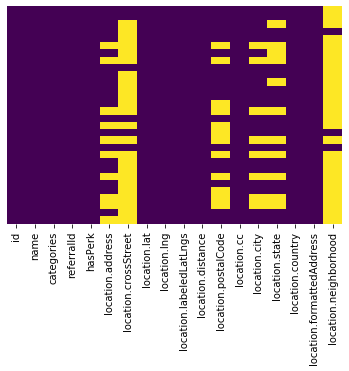

In [20]:
#Plotting null values using sns
sns.heatmap(data.isnull(), yticklabels=False, cbar= False, cmap='viridis')

Getting rid of CROSS STREET, POSTAL CODE, CITY, STATE, COUNTRY, NEIGHBORHOOD, HAS PERK, REFFERAL ID

In [21]:
# Cleaning the datafram DATA
    
filtered_col = ['id','name','categories']+[col for col in data.columns if col.startswith ('location.')]

#Creating a new_df with filtered columns

search_df = data.loc[:,filtered_col]
search_df['categories']=search_df.apply(category_type,axis=1)
search_df.columns = [column.split('.')[-1] for column in search_df.columns]

#dropping unwanted columns

search_df.drop(['labeledLatLngs','postalCode','cc','city','state','country','crossStreet','neighborhood'],axis = 1, inplace = True)
search_df.rename(columns={'id':'ID','name':'Name','categories':'Category','lat':'Latitude','lng':'Longitude','address':'Address','formattedAddress':'Detailed Address','distance':'Distance'}, inplace = True)
search_df.replace(np.nan, 'Not Mentioned', inplace= True)    

print(search_df.head())
print(search_df.shape)

                         ID                                           Name  \
0  5079a1d0498ec6be8d9d88d9                              Bill's Restaurant   
1  4bc6fffc2f94d13a8a10117f       Cardiff University Trevithick Restaurant   
2  4bb4b156613fb7130e0a94e6                              Restaurant Minuet   
3  4c23a61ef1272d7fe9c481c5                 Riverside Cantonese Restaurant   
4  5b54976383e380002c83f883  The Restaurant & Bar at Clayton Hotel Cardiff   

             Category               Address   Latitude  Longitude  Distance  \
0  English Restaurant  27-39 Wyndham Arcade  51.477874  -3.175822       481   
1   College Cafeteria          5 The Parade  51.484519  -3.170129       704   
2  Italian Restaurant      42 Castle Arcade  51.480996  -3.181087       150   
3  Chinese Restaurant         Leckwith Road  51.477772  -3.201222      1587   
4           Hotel Bar            St Mary St  51.476196  -3.176718       631   

                                    Detailed Address  
0

In [22]:
search_df

,ID,Name,Category,Address,Latitude,Longitude,Distance,Detailed Address
0,5079a1d0498ec6be8d9d88d9,Bill's Restaurant,English Restaurant,27-39 Wyndham Arcade,51.477874,-3.175822,481,"[27-39 Wyndham Arcade (Mill Ln), Cardiff, CF10..."
1,4bc6fffc2f94d13a8a10117f,Cardiff University Trevithick Restaurant,College Cafeteria,5 The Parade,51.484519,-3.170129,704,"[5 The Parade (Queen's Buildings), Cardiff, CF..."
2,4bb4b156613fb7130e0a94e6,Restaurant Minuet,Italian Restaurant,42 Castle Arcade,51.480996,-3.181087,150,"[42 Castle Arcade, Cardiff, CF10 1BW, United K..."
3,4c23a61ef1272d7fe9c481c5,Riverside Cantonese Restaurant,Chinese Restaurant,Leckwith Road,51.477772,-3.201222,1587,"[Leckwith Road, Cardiff, CF11 6AH, United King..."
4,5b54976383e380002c83f883,The Restaurant & Bar at Clayton Hotel Cardiff,Hotel Bar,St Mary St,51.476196,-3.176718,631,"[St Mary St, Cardiff, CF10 1GD, United Kingdom]"
5,519cbb16498e94d2371eb7b8,Pillars Restaurant,Food Truck,Not Mentioned,51.480870,-3.177420,150,[United Kingdom]
6,51efde082fc65fccf9370319,Castell's Restaurant,Restaurant,Castle Street,51.480875,-3.182924,272,"[Castle Street, Cardiff, CF10 1SZ, United King..."
7,4ea2bd138231f6dc6a243313,Style Restaurant,Café,Not Mentioned,51.482369,-3.174849,311,[United Kingdom]
8,4f450adee4b00b32e041dcf8,IKEA Restaurant and Café,Scandinavian Restaurant,IKEA,51.462658,-3.188317,2207,"[IKEA (Cardiff Bay Retail Park), Cardiff, CF11..."
9,4bcdc6128920b713d639a0dc,Valentino's Restaurant,Italian Restaurant,5 Windsor Place,51.483365,-3.173055,466,"[5 Windsor Place, Cardiff, CF10 3BD, United Ki..."


Finding similar ones and merging 2 dataframes

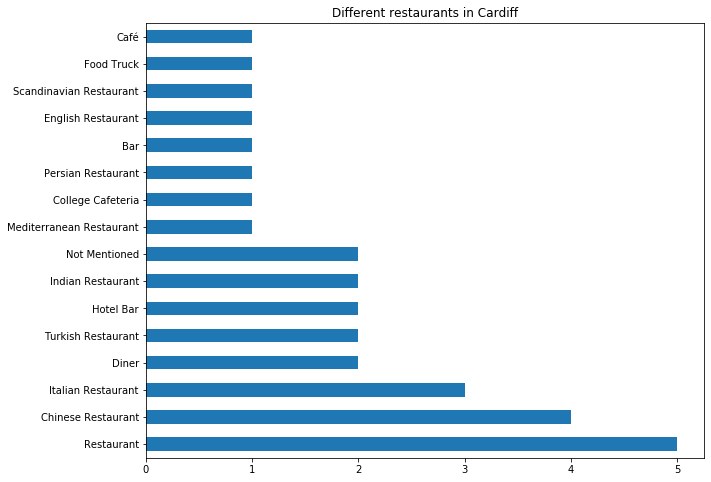

In [23]:
# Visualizing the dataset

search_df['Category'].replace({'Not mentioned':'Chinese Restaurant'}, inplace =True)
search_df['Category'].value_counts().plot(kind= 'barh',title = 'Different restaurants in Cardiff', figsize = (10,8))


In [24]:
# Finding more Italian Restaurants

In [25]:
location = 'Cardiff'

radius = 500
limit = 20

address = location
geolocator = Nominatim(user_agent='foursquare_agent')
loc = geolocator.geocode(address)
latitude = loc.latitude
longitude = loc.longitude
    
url = 'https://api.foursquare.com/v2/venues/{}/similar?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit{}'.format('58e1418e528930451aeb12f3',client_id,client_secret,version,latitude,longitude,radius,limit)
    
results = requests.get(url).json()

items = results['response']['similarVenues']['items']
similar = pd.json_normalize(items)

print(similar)

Empty DataFrame
Columns: []
Index: []


In [27]:
# Extracting Chinese restaurants

chinese = search_df.loc[search_df['Category']=='Chinese Restaurant']
#chinese.drop(columns = ['neighborhood'],inplace = True)
print(chinese.shape)
print(chinese.head())

(4, 8)
                          ID                            Name  \
3   4c23a61ef1272d7fe9c481c5  Riverside Cantonese Restaurant   
11  5d71d8f0665a760007b28553     Star Chinese Restaurant 金满楼   
12  5942db46f2905e37c0dd795e       No. 23 Chinese Restaurant   
21  58e1418e528930451aeb12f3    Fairyland Chinese restaurant   

              Category             Address   Latitude  Longitude  Distance  \
3   Chinese Restaurant       Leckwith Road  51.477772  -3.201222      1587   
11  Chinese Restaurant    23 Churchill Way  51.481498  -3.172221       483   
12  Chinese Restaurant    23 Churchill Way  51.481632  -3.172262       480   
21  Chinese Restaurant  116 Salisbury Road  51.489556  -3.174021       949   

                                     Detailed Address  
3   [Leckwith Road, Cardiff, CF11 6AH, United King...  
11  [23 Churchill Way, Cardiff, CF10 2HE, United K...  
12  [23 Churchill Way, Cardiff, C F10, United King...  
21  [116 Salisbury Road, Cardiff, CF24 4AE, United...  


Plotting this on the map

In [28]:
Restaurant = folium.Map([51.481583,-3.179090],zoom_start= 13)

latitudes = search_df.Latitude
longitudes = search_df.Longitude
label = search_df.Name

for lat,lon,label in zip(latitudes,longitudes,label):
    folium.CircleMarker([lat,lon],radius=5,popup=label,color='green',fill=True,fill_opacity = 0.5).add_to(Restaurant)

for lat,lon,label in zip(chinese.Latitude,chinese.Longitude,chinese.Name):
    folium.Marker([lat,lon],radius=4,popup=label,color='yellow',fill=True,fill_opacity = 0.5).add_to(Restaurant)

Restaurant

# Looping restaurants to get more venues

Creating a dataframe of venues around the restaurants to get more insight

In [29]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            client_id, 
            client_secret, 
            version, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['R_name', 
                  'R_Latitude', 
                  'R_Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [31]:
restaurant_venues = getNearbyVenues(names=search_df['Name'],
                                   latitudes=search_df['Latitude'],
                                   longitudes=search_df['Longitude']
                                  )

In [32]:
print(restaurant_venues.shape)
restaurant_venues.head()


(576, 7)


,R_name,R_Latitude,R_Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bill's Restaurant,51.477874,-3.175822,Uncommon Ground Coffee Co.,51.478297,-3.177394,Coffee Shop
1,Bill's Restaurant,51.477874,-3.175822,The Plan,51.478930,-3.177093,Café
2,Bill's Restaurant,51.477874,-3.175822,Wahaca,51.478059,-3.175173,Mexican Restaurant
3,Bill's Restaurant,51.477874,-3.175822,Miller & Carter,51.479687,-3.176286,Steakhouse
4,Bill's Restaurant,51.477874,-3.175822,St David's Dewi Sant,51.479429,-3.175565,Shopping Mall


Visualizing the count of all venues

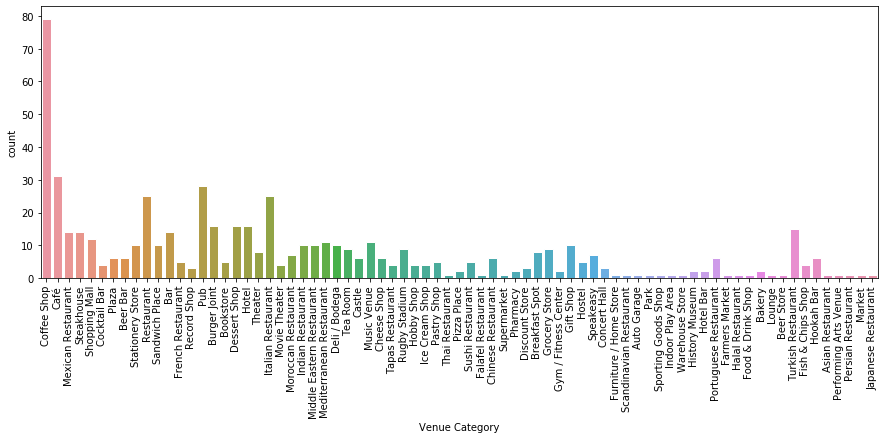

In [33]:
plt.figure(figsize=(15,5))  #adjusts the x & y axis
plt.xticks(rotation=90) #Helps in adjusting x-ticks
sns.set_style('darkgrid')
plot = sns.countplot(x= 'Venue Category', data = restaurant_venues)

Coffee shops are famous in the region that the user mentioned.

Lets find a suitable locality for coffee shops

Now we want such a locality(in our case R_name) which has less coffee shop category around it.

In [34]:
restaurant_venues.groupby('R_name').count()

,R_Latitude,R_Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
R_name,,,,,,
Al-Rayan Restaurant,20,20,20,20,20,20
Alwaly Omani Restaurant,20,20,20,20,20,20
Bill's Restaurant,20,20,20,20,20,20
Cardiff University Trevithick Restaurant,20,20,20,20,20,20
Castell's Restaurant,20,20,20,20,20,20
Collage Restaurant,20,20,20,20,20,20
Fairyland Chinese restaurant,20,20,20,20,20,20
Heathfields Restaurant,11,11,11,11,11,11
IKEA Restaurant and Café,10,10,10,10,10,10


In [36]:
print('There are {} uniques categories.'.format(len(restaurant_venues['Venue Category'].unique())))

There are 75 uniques categories.


# Analyzing each R_name

In [37]:
# one hot encoding
R_onehot = pd.get_dummies(restaurant_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
R_onehot['R_name'] = restaurant_venues['R_name'] 

# move neighborhood column to the first column
fixed_columns = [R_onehot.columns[-1]] + list(R_onehot.columns[:-1])
R_onehot = R_onehot[fixed_columns]
print(R_onehot.shape)
R_onehot.head()

(576, 76)


,R_name,Asian Restaurant,Auto Garage,Bakery,Bar,Beer Bar,Beer Store,Bookstore,Breakfast Spot,Burger Joint,...,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Turkish Restaurant,Warehouse Store
0,Bill's Restaurant,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bill's Restaurant,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bill's Restaurant,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bill's Restaurant,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,Bill's Restaurant,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# Groupping the values
R_grouped = R_onehot.groupby('R_name').mean().reset_index()
print(R_grouped.shape)
R_grouped.head()

(30, 76)


,R_name,Asian Restaurant,Auto Garage,Bakery,Bar,Beer Bar,Beer Store,Bookstore,Breakfast Spot,Burger Joint,...,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Turkish Restaurant,Warehouse Store
0,Al-Rayan Restaurant,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.05,0.0,0.0,0.00,0.0,0.0,0.00,0.05,0.0
1,Alwaly Omani Restaurant,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.05,0.00,...,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.10,0.0
2,Bill's Restaurant,0.0,0.0,0.0,0.05,0.05,0.0,0.05,0.00,0.05,...,0.05,0.05,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0
3,Cardiff University Trevithick Restaurant,0.0,0.0,0.0,0.05,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.05,0.00,0.0
4,Castell's Restaurant,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.0,0.0,0.05,0.1,0.0,0.00,0.00,0.0


# K-Means Clustering 

In [39]:
#Importing Kmeans

from sklearn.cluster import KMeans

In [40]:
# set number of clusters
kclusters = 5

R_clustering = R_grouped.drop('R_name', axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(R_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 3, 2, 0, 3, 1, 4, 4, 3], dtype=int32)

In [41]:
# creating a new_df with cluster label and most common venue in r_name 
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Creating the dataframe

In [42]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['R_name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['R_name'] = R_grouped['R_name']

for ind in np.arange(R_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(R_grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

,R_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Al-Rayan Restaurant,Italian Restaurant,Hotel,Coffee Shop,Sandwich Place,Pub,Restaurant,Mediterranean Restaurant,Moroccan Restaurant,Grocery Store,Dessert Shop
1,Alwaly Omani Restaurant,Turkish Restaurant,Italian Restaurant,Hookah Bar,Sandwich Place,Moroccan Restaurant,Dessert Shop,Middle Eastern Restaurant,Mexican Restaurant,Pub,Coffee Shop
2,Bill's Restaurant,Coffee Shop,Café,Sandwich Place,Plaza,Record Shop,Restaurant,Cocktail Bar,Shopping Mall,Burger Joint,Stationery Store
3,Cardiff University Trevithick Restaurant,Coffee Shop,Hotel,Italian Restaurant,Pub,Restaurant,Indian Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Movie Theater
4,Castell's Restaurant,Pub,Tea Room,Rugby Stadium,Deli / Bodega,Coffee Shop,Restaurant,Cheese Shop,Music Venue,Café,Hostel


In [43]:
# add clustering labels
venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

venue_merged = search_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
venue_merged = venue_merged.join(venues_sorted.set_index('R_name'), on='Name')

venue_merged.head() # check the last columns!

,ID,Name,Category,Address,Latitude,Longitude,Distance,Detailed Address,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,5079a1d0498ec6be8d9d88d9,Bill's Restaurant,English Restaurant,27-39 Wyndham Arcade,51.477874,-3.175822,481,"[27-39 Wyndham Arcade (Mill Ln), Cardiff, CF10...",3,Coffee Shop,Café,Sandwich Place,Plaza,Record Shop,Restaurant,Cocktail Bar,Shopping Mall,Burger Joint,Stationery Store
1,4bc6fffc2f94d13a8a10117f,Cardiff University Trevithick Restaurant,College Cafeteria,5 The Parade,51.484519,-3.170129,704,"[5 The Parade (Queen's Buildings), Cardiff, CF...",2,Coffee Shop,Hotel,Italian Restaurant,Pub,Restaurant,Indian Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Movie Theater
2,4bb4b156613fb7130e0a94e6,Restaurant Minuet,Italian Restaurant,42 Castle Arcade,51.480996,-3.181087,150,"[42 Castle Arcade, Cardiff, CF10 1BW, United K...",0,Deli / Bodega,Coffee Shop,Tea Room,Pub,Rugby Stadium,Castle,Café,Restaurant,Cheese Shop,Music Venue
3,4c23a61ef1272d7fe9c481c5,Riverside Cantonese Restaurant,Chinese Restaurant,Leckwith Road,51.477772,-3.201222,1587,"[Leckwith Road, Cardiff, CF11 6AH, United King...",4,Chinese Restaurant,Grocery Store,Breakfast Spot,Pharmacy,Pizza Place,Coffee Shop,Pub,Falafel Restaurant,Discount Store,Indian Restaurant
4,5b54976383e380002c83f883,The Restaurant & Bar at Clayton Hotel Cardiff,Hotel Bar,St Mary St,51.476196,-3.176718,631,"[St Mary St, Cardiff, CF10 1GD, United Kingdom]",3,Coffee Shop,Sandwich Place,Burger Joint,Cocktail Bar,Pub,Record Shop,Restaurant,Rugby Stadium,Café,Shopping Mall


In [44]:
venue_merged.shape

(30, 19)

In [45]:
label_group = venue_merged.iloc[:, 0:9]
label_group.drop(columns=['Address','Distance','Detailed Address'], axis =1 , inplace = True)
label_group.groupby('Cluster Labels')
label_group.head()

,ID,Name,Category,Latitude,Longitude,Cluster Labels
0,5079a1d0498ec6be8d9d88d9,Bill's Restaurant,English Restaurant,51.477874,-3.175822,3
1,4bc6fffc2f94d13a8a10117f,Cardiff University Trevithick Restaurant,College Cafeteria,51.484519,-3.170129,2
2,4bb4b156613fb7130e0a94e6,Restaurant Minuet,Italian Restaurant,51.480996,-3.181087,0
3,4c23a61ef1272d7fe9c481c5,Riverside Cantonese Restaurant,Chinese Restaurant,51.477772,-3.201222,4
4,5b54976383e380002c83f883,The Restaurant & Bar at Clayton Hotel Cardiff,Hotel Bar,51.476196,-3.176718,3


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

/home/simran/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 37329 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/simran/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 28385 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/simran/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 27004 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/simran/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 37329 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/simran/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 28385 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/simran/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180

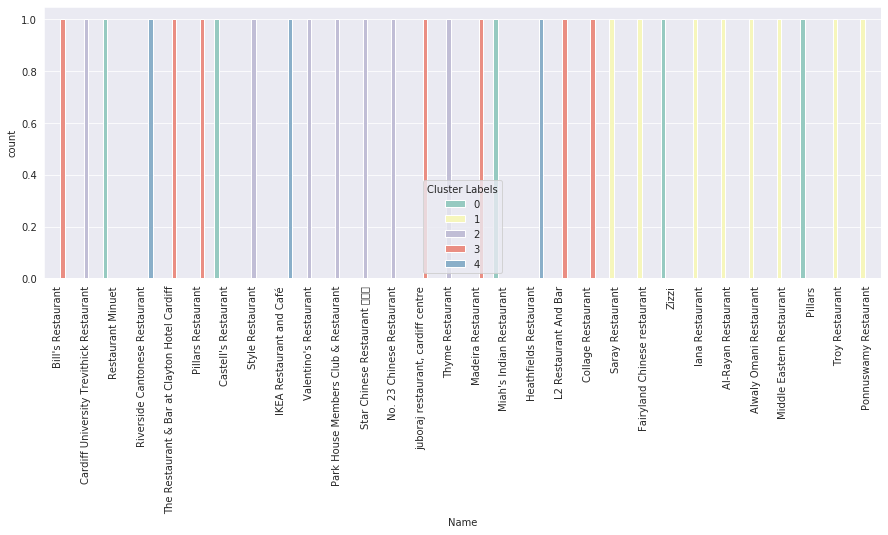

In [46]:
plt.figure(figsize=(15,5))
sns.countplot(x='Name',data=label_group,hue= 'Cluster Labels', palette="Set3")
sns.set_style('whitegrid')
plt.xticks(rotation=90)

In [47]:
label_group['Cluster Labels'].value_counts()

1    8
3    7
2    7
0    5
4    3
Name: Cluster Labels, dtype: int64

# Evaluating Clusters

Examining each clusters and finding the key distinguishable points

In [55]:
venue_merged.loc[venue_merged['Cluster Labels'] == 0, venue_merged.columns[[1] + list(range(4, venue_merged.shape[1]))]]

,Name,Latitude,Longitude,Distance,Detailed Address,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Restaurant Minuet,51.480996,-3.181087,150,"[42 Castle Arcade, Cardiff, CF10 1BW, United K...",0,Deli / Bodega,Coffee Shop,Tea Room,Pub,Rugby Stadium,Castle,Café,Restaurant,Cheese Shop,Music Venue
6,Castell's Restaurant,51.480875,-3.182924,272,"[Castle Street, Cardiff, CF10 1SZ, United King...",0,Pub,Tea Room,Rugby Stadium,Deli / Bodega,Coffee Shop,Restaurant,Cheese Shop,Music Venue,Café,Hostel
16,Miah's Indian Restaurant,51.478537,-3.185263,545,"[Swansea, City and County of Swansea, United K...",0,Hostel,Rugby Stadium,Pub,Farmers Market,Italian Restaurant,Cheese Shop,Castle,Pastry Shop,Halal Restaurant,Beer Bar
22,Zizzi,51.480723,-3.180434,134,"[27 High Street, Cardiff, CF10 1PU, United Kin...",0,Pub,Coffee Shop,Rugby Stadium,Deli / Bodega,Restaurant,Cheese Shop,Music Venue,Café,Castle,Beer Bar
27,Pillars,51.481915,-3.177360,130,[United Kingdom],0,Coffee Shop,Deli / Bodega,Pub,Café,Italian Restaurant,Market,Gift Shop,Concert Hall,Restaurant,Cheese Shop


In [56]:
venue_merged.loc[venue_merged['Cluster Labels'] == 1, venue_merged.columns[[1] + list(range(4, venue_merged.shape[1]))]]

,Name,Latitude,Longitude,Distance,Detailed Address,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Saray Restaurant,51.490210,-3.169716,1157,[United Kingdom],1,Middle Eastern Restaurant,Turkish Restaurant,Grocery Store,Coffee Shop,Restaurant,Mexican Restaurant,Chinese Restaurant,Mediterranean Restaurant,Dessert Shop,Café
21,Fairyland Chinese restaurant,51.489556,-3.174021,949,"[116 Salisbury Road, Cardiff, CF24 4AE, United...",1,Turkish Restaurant,Pub,Asian Restaurant,Restaurant,History Museum,Indian Restaurant,Mediterranean Restaurant,Mexican Restaurant,Music Venue,Fish & Chips Shop
23,lana Restaurant,51.487663,-3.167638,1043,[United Kingdom],1,Coffee Shop,Turkish Restaurant,Italian Restaurant,Café,Restaurant,Mexican Restaurant,Sandwich Place,Mediterranean Restaurant,Middle Eastern Restaurant,Moroccan Restaurant
24,Al-Rayan Restaurant,51.486574,-3.166262,1050,"[42 City Rd, Cardiff, CF24 3DL, United Kingdom]",1,Italian Restaurant,Hotel,Coffee Shop,Sandwich Place,Pub,Restaurant,Mediterranean Restaurant,Moroccan Restaurant,Grocery Store,Dessert Shop
25,Alwaly Omani Restaurant,51.488040,-3.167308,1088,"[City RD, Cathays, Cardiff, United Kingdom]",1,Turkish Restaurant,Italian Restaurant,Hookah Bar,Sandwich Place,Moroccan Restaurant,Dessert Shop,Middle Eastern Restaurant,Mexican Restaurant,Pub,Coffee Shop
26,Middle Eastern Restaurant,51.488002,-3.167371,1082,[United Kingdom],1,Turkish Restaurant,Italian Restaurant,Hookah Bar,Sandwich Place,Moroccan Restaurant,Dessert Shop,Middle Eastern Restaurant,Mexican Restaurant,Pub,Coffee Shop
28,Troy Restaurant,51.490910,-3.170415,1196,"[192 City Road, Cardiff, CF24 3JF, United King...",1,Middle Eastern Restaurant,Turkish Restaurant,Café,Pub,Coffee Shop,Restaurant,Mexican Restaurant,Chinese Restaurant,Mediterranean Restaurant,Fish & Chips Shop
29,Ponnuswamy Restaurant,51.489700,-3.169287,1128,"[Cardiff, CF24 3BQ, United Kingdom]",1,Coffee Shop,Turkish Restaurant,Fish & Chips Shop,Grocery Store,Restaurant,Mexican Restaurant,Chinese Restaurant,Mediterranean Restaurant,Dessert Shop,Café


In [57]:
venue_merged.loc[venue_merged['Cluster Labels'] == 2, venue_merged.columns[[1] + list(range(4, venue_merged.shape[1]))]]

,Name,Latitude,Longitude,Distance,Detailed Address,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Cardiff University Trevithick Restaurant,51.484519,-3.170129,704,"[5 The Parade (Queen's Buildings), Cardiff, CF...",2,Coffee Shop,Hotel,Italian Restaurant,Pub,Restaurant,Indian Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Movie Theater
7,Style Restaurant,51.482369,-3.174849,311,[United Kingdom],2,Coffee Shop,Concert Hall,Restaurant,Café,Burger Joint,Hotel,Shopping Mall,Speakeasy,Gift Shop,Steakhouse
9,Valentino's Restaurant,51.483365,-3.173055,466,"[5 Windsor Place, Cardiff, CF10 3BD, United Ki...",2,Coffee Shop,Hotel,Theater,Speakeasy,Dessert Shop,Movie Theater,Pub,Gift Shop,Restaurant,Burger Joint
10,Park House Members Club & Restaurant,51.484933,-3.175978,427,"[20 Park Place, Cardiff, CF10 3DQ, United King...",2,Coffee Shop,Hotel,Italian Restaurant,Pub,Gift Shop,Dessert Shop,Hotel Bar,Restaurant,Café,History Museum
11,Star Chinese Restaurant 金满楼,51.481498,-3.172221,483,"[23 Churchill Way, Cardiff, CF10 2HE, United K...",2,Coffee Shop,Bar,Shopping Mall,Italian Restaurant,Gift Shop,Mediterranean Restaurant,Movie Theater,Dessert Shop,Portuguese Restaurant,Café
12,No. 23 Chinese Restaurant,51.481632,-3.172262,480,"[23 Churchill Way, Cardiff, C F10, United King...",2,Coffee Shop,Bar,Shopping Mall,Italian Restaurant,Gift Shop,Mediterranean Restaurant,Movie Theater,Dessert Shop,Portuguese Restaurant,Café
14,Thyme Restaurant,51.481105,-3.171504,536,[United Kingdom],2,Coffee Shop,Stationery Store,Restaurant,Theater,Dessert Shop,Gift Shop,Bar,Concert Hall,Steakhouse,Portuguese Restaurant


In [58]:
venue_merged.loc[venue_merged['Cluster Labels'] == 3, venue_merged.columns[[1] + list(range(4, venue_merged.shape[1]))]]

,Name,Latitude,Longitude,Distance,Detailed Address,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bill's Restaurant,51.477874,-3.175822,481,"[27-39 Wyndham Arcade (Mill Ln), Cardiff, CF10...",3,Coffee Shop,Café,Sandwich Place,Plaza,Record Shop,Restaurant,Cocktail Bar,Shopping Mall,Burger Joint,Stationery Store
4,The Restaurant & Bar at Clayton Hotel Cardiff,51.476196,-3.176718,631,"[St Mary St, Cardiff, CF10 1GD, United Kingdom]",3,Coffee Shop,Sandwich Place,Burger Joint,Cocktail Bar,Pub,Record Shop,Restaurant,Rugby Stadium,Café,Shopping Mall
5,Pillars Restaurant,51.480870,-3.177420,150,[United Kingdom],3,Coffee Shop,Café,Deli / Bodega,Restaurant,Bookstore,Gift Shop,Cheese Shop,Castle,Shopping Mall,Pastry Shop
13,"juboraj restaurant, cardiff centre",51.477341,-3.176413,517,"[cardiff, Cardiff, United Kingdom]",3,Coffee Shop,Café,Sandwich Place,Plaza,Record Shop,Restaurant,Cocktail Bar,Shopping Mall,Burger Joint,Stationery Store
15,Madeira Restaurant,51.480282,-3.171007,587,"[2 Guildford Crescent (Adamsdown), Cardiff, CF...",3,Coffee Shop,Burger Joint,Café,Gift Shop,Portuguese Restaurant,Mexican Restaurant,Restaurant,Shopping Mall,Speakeasy,Plaza
18,L2 Restaurant And Bar,51.479008,-3.171343,618,[United Kingdom],3,Coffee Shop,Burger Joint,Café,Gift Shop,Restaurant,Sandwich Place,Plaza,Shopping Mall,Speakeasy,Stationery Store
19,Collage Restaurant,51.476917,-3.173570,655,"[Meridian Gate (Bute Terrace), Cardiff, CF10 2...",3,Coffee Shop,Burger Joint,Café,Stationery Store,Pub,Sandwich Place,Portuguese Restaurant,Shopping Mall,Plaza,Steakhouse


As the most frequent venue is coffee shop, the investor will be likely to choose a coffee shop. Now the desired location will be in a city center and in such an area which does not have much cafes

So, from the above for clusters, looking into first 3 to 4 most common venues which do not include coffee shop, we have the following desirable order

cluster 2 --> cluster 1 --> cluster 4 --> cluster 3

Here, we will choose cluster 2 as it is the most optimal dataframe

In [59]:
cluster_2 = venue_merged.loc[venue_merged['Cluster Labels'] == 1, venue_merged.columns[[1] + list(range(4, venue_merged.shape[1]))]]

In [60]:
location = 'Cardiff,United Kingdom'
    
address = location
geolocator = Nominatim(user_agent='foursquare_agent')
loc = geolocator.geocode(address)
latitude = loc.latitude
longitude = loc.longitude

cluster = folium.Map([latitude,longitude],zoom_start= 13,prefer_canvas = True)

# Adding investor's location
folium.CircleMarker([51.481583,-3.179090],radius=5,color='red',fill=True,fill_opacity = 0.5).add_to(cluster)

for lat,lon,label in zip(cluster_2['Latitude'],cluster_2['Longitude'],cluster_2['Name']):
    folium.Marker([lat,lon],popup=label).add_to(cluster)

cluster  

So, the location should be near cathays
Cathays is closeby to Cardiff University and city center
Also Cathays has lot of residential buildings with student residents, therfore making it an optimum location

Now, the locations are restaurants name but the area / neighborhood is CATHAYS

The data frame for the user will be 

In [67]:
user = cluster_2[['Name','Latitude','Longitude','Detailed Address']].reset_index()
user.drop(columns=['index'],axis=1,inplace=True)
user

,Name,Latitude,Longitude,Detailed Address
0,Saray Restaurant,51.490210,-3.169716,[United Kingdom]
1,Fairyland Chinese restaurant,51.489556,-3.174021,"[116 Salisbury Road, Cardiff, CF24 4AE, United..."
2,lana Restaurant,51.487663,-3.167638,[United Kingdom]
3,Al-Rayan Restaurant,51.486574,-3.166262,"[42 City Rd, Cardiff, CF24 3DL, United Kingdom]"
4,Alwaly Omani Restaurant,51.488040,-3.167308,"[City RD, Cathays, Cardiff, United Kingdom]"
5,Middle Eastern Restaurant,51.488002,-3.167371,[United Kingdom]
6,Troy Restaurant,51.490910,-3.170415,"[192 City Road, Cardiff, CF24 3JF, United King..."
7,Ponnuswamy Restaurant,51.489700,-3.169287,"[Cardiff, CF24 3BQ, United Kingdom]"


# Thank You!